# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report

import os
os.makedirs('saved_models', exist_ok=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy
TRANSFORMER_MODEL_NAME = 'bert-base-uncased'
SAVE_MODEL_SUFFIX = '1'
save_model_name = TRANSFORMER_MODEL_NAME.split('/')[-1]
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

nr_features = 768
batch_size = 16
learning_rate = 2e-5
epochs = 10
patience = 2
class_weight_beta = 0.9999

In [3]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [4]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    tokens_list = []
    agent_act_types_list = []
    
    nr = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                user_utterance = utterance
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            # if speaker == 0:
            #     # if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
            #         # skip_bot = True
            #         # continue
                
            #     if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     skip_bot = False
            # else:
            #     if skip_bot:
            #         continue
            if speaker == 0:
                skip_bot = False
                if not any(da.startswith("Hotel") or da.startswith("Restaurant") or da.startswith("Booking") for da in act_types):
                    skip_bot = True
                    continue
            elif skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # to_be_retrieved.add(domain + '-availability')
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                elif domain in ["hotel", "restaurant", "booking", "general"]: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name + ':' + slot_value for slot_name, slot_value in act_type_relevant_slots]))
                    
                    if len(to_be_retrieved) != 0 and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in to_be_retrieved)) and not "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability:yes')
                    elif "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability:no')
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                to_be_retrieved_list.append(list(to_be_retrieved))
                agent_act_types_list.append(act_types)
                
                print(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                input_text = user_utterance + ' | ' + ', '.join(user_slots_per_act_type) + ' | ' + ', '.join(to_be_retrieved)
                print(input_text)
                
                tokenized = transformer_tokenizer(input_text, padding = 'max_length')
                
                tokens_list.append(tokenized)
            
    return tokens_list, agent_act_types_list

In [5]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_agent_act_types_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_agent_act_types_list = extract_to_be_retrieved_info(test)
    val_embeddings_list, val_agent_act_types_list = extract_to_be_retrieved_info(val)

Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset multi_woz_v22 downloaded and prepared to /root/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/7452f16a8b502e97df5c04cc4ee5436464762fa93b1ce778dd14181e79d8b51a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  1%|          | 54/6321 [00:00<00:12, 512.43it/s]

['Restaurant-Inform' 'Restaurant-Select']
i need a place to dine in the center thats expensive | restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-choice:several, restaurant-availability:yes, restaurant-food:British, restaurant-food:African, restaurant-food:Asian
['Restaurant-Inform']
Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation? | restaurant-request-food:? | restaurant-food:Afrian, restaurant-name:Bedouin, restaurant-area:centre, restaurant-availability:yes
['Hotel-Recommend' 'Restaurant-Inform']
Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel? | hotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:? | restaurant-name:Bedouin, hotel-name:the University Arms Hotel, hotel-area:center of town, restaurant-availability:yes, restaurant-phone:01223367660, hotel-availability:yes
['Booking-Request']
Yes. Can you b

  3%|▎         | 167/6321 [00:00<00:12, 512.11it/s]

['Booking-Book' 'general-reqmore']
Sure, Saturday for 5 nights and 7 people. | hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | hotel-ref:G7TDBIJU, hotel-name:Worth House, hotel-availability:yes, general-availability:yes
['Hotel-Inform' 'general-reqmore']
Does the Worth House have a star rating of 4? | hotel-inform-stars:4 | hotel-stars:4, hotel-name:Worth House, hotel-availability:yes, general-availability:yes
['Booking-Book']
Can you book the worth house for 5 nights starting saturday for 7 people. | hotel-inform-bookstay:5 | hotel-ref:G7TDBIJU, hotel-availability:yes
['Restaurant-Request']
I want something that's moderately priced. Any type of food. | restaurant-inform-food:dontcare, restaurant-inform-pricerange:moderate, restaurant-request-food:? | 
['Restaurant-Inform' 'general-reqmore']
I would like the north part of town, please. | restaurant-inform-area:north | general-availability:yes, restaurant-food:Chinese, restaurant-name:Golden Wok, rest

  4%|▍         | 268/6321 [00:00<00:12, 478.05it/s]

['Booking-Inform']
I would prefer the cheap price range. | hotel-inform-pricerange:cheap | hotel-name:worth house, hotel-availability:yes
['Hotel-Inform']
What is the price of the Worth House? | hotel-inform-name:worth house | hotel-phone:01223316074, hotel-availability:yes
['Booking-Book' 'general-reqmore']
can you book a room for tuesday, 5 nights, 5 people. | hotel-inform-bookday:tuesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | general-availability:yes, hotel-bookstay:5, hotel-name:Worth House, hotel-availability:yes, hotel-ref:GWIK59YW
['Restaurant-Inform']
Can you help me find a restaurant as well? |  | restaurant-area:north, restaurant-choice:9, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Recommend']
The restaurant should be in the same area as the hotel and should be in the expensive price | restaurant-inform-area:north, restaurant-inform-pricerange:expensive | restaurant-name:Saigon City, restaurant-choice:many, restaurant-availability:yes
['Restau

  6%|▌         | 373/6321 [00:00<00:11, 502.07it/s]

['Restaurant-Inform']
What is the price range of that restaurant? |  | restaurant-food:Korean, restaurant-pricerange:expensive, restaurant-name:Little Seoul, restaurant-availability:yes
['Booking-Request' 'Restaurant-Inform']
Is that in the centre area? If so I'd like a reservation for 7 on Friday please. | restaurant-inform-area:centre, restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7 | restaurant-name:Little Seoul, restaurant-area:centre, restaurant-availability:yes
['Booking-Request']
Yes can you please and send me the reference number. | restaurant-request-ref:? | 
['Booking-Book']
Can you reserve a table for Friday for 7 people at 15:45? | restaurant-inform-booktime:15:45 | 
['Booking-Book' 'general-reqmore']
what is the reference number? | restaurant-request-ref:? | restaurant-ref:A5LITXVZ, general-availability:yes, restaurant-availability:yes
['Booking-Request']
I'm looking for a moderate priced place to stay with free wifi. | hotel-inform-internet:yes, hotel-inf

  7%|▋         | 474/6321 [00:00<00:11, 493.73it/s]

['Booking-Inform' 'Restaurant-Inform']
Yes, I would prefer chinese please. | restaurant-inform-food:chinese | restaurant-name:tang chinese restaurant, restaurant-address:napier street city centre, restaurant-availability:yes
['Booking-Inform']
Yes. Make a reservation for 8 people on Monday at 11:30. | restaurant-inform-bookpeople:8, restaurant-inform-booktime:11:30 | 
['Booking-Book' 'general-reqmore']
Please book the restaurant as requested. I would also like the reference number. | restaurant-request-ref:? | restaurant-ref:JCH9E5BI, general-availability:yes, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Can you help me find an expensive restaurant in the west? | restaurant-inform-area:west, restaurant-inform-pricerange:expensive | restaurant-choice:nine, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Recommend']
I was hoping for Indian food. | restaurant-inform-food:indian | restaurant-name:india house, restaurant-availability:yes, restaurant-ch

  9%|▉         | 572/6321 [00:01<00:12, 468.26it/s]

['Booking-Request']
Yes, that would be great. Please book that for me. |  | 
['Restaurant-Inform' 'general-reqmore']
No but could I get the postcode, address, and phone number? | restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | general-availability:yes, restaurant-availability:yes, restaurant-address:6 Lensfield Road, restaurant-postcode:cb21eg, restaurant-phone:01223323361
['Train-OfferBook']
I need the postcode for the museum also. And I need to book a taxi from The Oak Bistro to the Primavera, I'd like to leave the restaurant by 07:45. | restaurant-request-address:?, taxi-inform-leaveat:07:45 | 
['Restaurant-Inform']
Oh wait, before you book that. I am rethinking my restaurant choice. I need British food. Does Oak Bistro serve British food? | restaurant-inform-food:british | restaurant-food:British, restaurant-name:Oak Bistro, restaurant-availability:yes
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Select']
I am looking for a restaurant 

 11%|█         | 670/6321 [00:01<00:12, 469.86it/s]

['Booking-Request']
I will be staying for 3 nights. | hotel-inform-bookstay:3 | 
['Booking-Book' 'general-reqmore']
2 people, is that fails then try 1 night. Please provide the reference number. | hotel-inform-bookpeople:2, hotel-request-ref:? | hotel-ref:WYO54VCI, hotel-availability:yes, general-availability:yes
['Booking-Inform' 'Restaurant-Inform']
I am looking for a restaurant called Charlie Chan | restaurant-inform-name:charlie chan | restaurant-address:Regent Street City Center, restaurant-name:Charlie Chan, restaurant-availability:yes
['Booking-Book']
yes please, for 1 person at 12:45 on Thursday, thank you | restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:45 | restaurant-ref:NL81FN41, restaurant-availability:yes
['Hotel-Inform' 'Hotel-Request']
I'm taking a trip in cambridge and need a place to stay. I would like a 4 star in the moderate price range. | hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-type:guesthous

 12%|█▏        | 767/6321 [00:01<00:17, 323.42it/s]

['Restaurant-NoOffer' 'Restaurant-Request']
I am looking for a restaurant in the expensive price range that serves Belgian food. | restaurant-inform-food:belgian, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Request']
Yes, is there any expensive European eateries? | restaurant-inform-food:european | restaurant-food:european, restaurant-choice:4, restaurant-pricerange:expensive, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
What is the address of the restaurant? | restaurant-request-address:? | restaurant-name:Michaelhouse Cafe, restaurant-address:St. Michael's Church Trinity Street City Centre, general-availability:yes, restaurant-availability:yes
['Restaurant-Inform']
What is its phone number? | restaurant-request-phone:? | restaurant-phone:01223 309147, restaurant-availability:yes
['Restaurant-Inform']
Okay, thanks. And what area is it in please? | restaurant-request-area:? | restaurant-area:centre, restaurant-availability:yes
['Res

 14%|█▎        | 862/6321 [00:02<00:14, 382.78it/s]

['Hotel-Inform' 'general-greet']
I think we're confusing each other. You said there was no 3-star hotel in the north, so I'm looking for a 3-star guesthouse in the north. Do you have that? | hotel-inform-area:north, hotel-inform-stars:3, hotel-inform-type:guesthouse | hotel-parking:yes, hotel-pricerange:moderate, general-availability:yes, hotel-stars:3, hotel-availability:yes, hotel-internet:yes, hotel-name:Alpha-milton guest house, hotel-area:north, hotel-type:guesthouse
['Attraction-Request' 'Hotel-Inform']
No worries, I just need the address please. | hotel-request-address:? | hotel-postcode:cb41xa, hotel-availability:yes, hotel-name:The Alpha-milton guest house, hotel-address:63 milton road
['Restaurant-Request']
Can you help me find a restaurant? |  | 
['Restaurant-Inform']
I'm actually looking for a particular restaurant recommended to me by the name of royal spice. | restaurant-inform-name:royal spice | restaurant-area:northern part of Cambridge, restaurant-address:Victoria Aven

 15%|█▌        | 958/6321 [00:02<00:12, 421.81it/s]

['Restaurant-Request']
I am looking for a vegetarian restaurant near South Cambridge, or a restaurant that has a variety of vegetarian dishes. | restaurant-inform-food:vegetarian | 
['Booking-Inform' 'Hotel-Inform']
Yes, I also need a place to stay I need a hotel that is expensive. | hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-parking:yes, hotel-pricerange:expensive, hotel-internet:yes, hotel-name:University arms hotel, hotel-area:centre, hotel-availability:yes
['Hotel-Inform' 'Hotel-Recommend']
Free parking isn't that expensive to me, are there any others or just the University Arms? | hotel-inform-parking:yes | hotel-pricerange:expensive, hotel-choice:5, hotel-area:Cambridge, hotel-availability:yes, hotel-name:Marriott
['Hotel-Inform' 'general-reqmore']
Does it have internet? | hotel-inform-internet:yes, hotel-request-internet:? | hotel-internet:yes, hotel-name:Huntingdon Marriott, hotel-availability:yes, general-availability:yes
['Booking-Inform' 'Restaurant-I

 17%|█▋        | 1059/6321 [00:02<00:11, 457.27it/s]

['Restaurant-Inform' 'general-reqmore']
No, the west part of town | restaurant-inform-area:west | restaurant-pricerange:moderate price, restaurant-food:Italian, general-availability:yes, restaurant-availability:yes, restaurant-food:British, restaurant-area:west part of town, restaurant-food:Indian
['Restaurant-Select']
What is the address? | restaurant-request-address:? | restaurant-food:British, restaurant-food:Italian, restaurant-food:Indian, restaurant-availability:yes
['Restaurant-Inform']
I don't have a preference as long as it's moderately priced and in the west part of town. | restaurant-inform-area:west, restaurant-inform-food:dontcare, restaurant-inform-pricerange:moderate | restaurant-address:205 Victoria Road Chesterton, restaurant-pricerange:moderate, restaurant-name:Meghna, restaurant-availability:yes, restaurant-area:west part of town, restaurant-food:Indian
['Hotel-Inform']
Could you give me some information on a hotel named el shaddai? | hotel-inform-name:el shaddai | h

 18%|█▊        | 1160/6321 [00:02<00:10, 475.32it/s]

['Restaurant-Inform']
Could I get address and postcode | restaurant-request-address:?, restaurant-request-postcode:? | 
[]
Well. I also need the hotel called Bridge Guest House. | hotel-inform-name:bridge guest house | 
['Booking-Book' 'general-reqmore']
I would like to know if you can book me a room for 5 nights starting Friday. I also need the reservation # | hotel-inform-bookday:friday, hotel-inform-bookstay:5 | hotel-name:the Bridge Guest House, general-availability:yes, hotel-bookday:Friday, hotel-bookstay:five, hotel-ref:R175R6S0, hotel-availability:yes
['Booking-Book']
I need the Bridge Guest House for 3 people. I forgot to include that. | hotel-inform-bookpeople:3 | hotel-bookpeople:3, hotel-ref:FW6X5F78, hotel-availability:yes
['Restaurant-NoOffer' 'Restaurant-Request']
I am looking for a restaurant serving Persian food in the expensive price range. | restaurant-inform-food:persian, restaurant-inform-pricerange:expensive | restaurant-food:Persian, restaurant-availability:yes
[

 20%|█▉        | 1260/6321 [00:02<00:10, 479.86it/s]

['Booking-Inform' 'Restaurant-Recommend']
In the centre please. And make it Portuguese. I don't care about price. I have no idea where I got the idea of cheap Italian from, smh. | hotel-request-pricerange:?, restaurant-inform-food:portuguese, restaurant-inform-pricerange:dontcare | restaurant-food:Portuguese, restaurant-availability:yes, restaurant-area:Centre, restaurant-pricerange:cheap, restaurant-name:Nandos City Centre
['Restaurant-NoOffer' 'general-reqmore']
i apologize. my husband wants something expensive. do you have any portuguese places that are expensive? | restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Select']
in that case what about french? | restaurant-inform-food:french | restaurant-area:north, restaurant-area:center, restaurant-choice:two, restaurant-availability:yes
['Restaurant-Inform']
I'd rather the one in the center. What is it called? | restaurant-inform-area:centre | restaurant-name:cote, restaurant-pricerange:expensive, restaurant-a

 22%|██▏       | 1367/6321 [00:03<00:09, 507.50it/s]

['Booking-Inform']
Can you try the other restaurant? |  | restaurant-name:nandos city centre, restaurant-availability:yes
['Booking-Book' 'general-reqmore']
Make the reservation for wednesday and then give me the reference number | restaurant-inform-bookday:wednesday | booking-availability:yes, booking-ref:CPD3XEJI, general-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
No thank you. I'm also looking for an expensive french restaurant. | restaurant-inform-food:french, restaurant-inform-pricerange:expensive | restaurant-area:north, restaurant-choice:2, restaurant-area:centre, restaurant-availability:yes
['Booking-Request']
the centre please. can you reserve a table for friday please. | restaurant-inform-area:centre, restaurant-inform-bookday:friday | 
['Booking-Book']
It will be for 2 people on friday at 15:30 | restaurant-inform-bookpeople:2, restaurant-inform-booktime:15:30 | restaurant-availability:yes, restaurant-bookday:Friday, restaurant-ref:6C4FPXC9, restaurant-bookp

 23%|██▎       | 1470/6321 [00:03<00:09, 488.23it/s]

['Hotel-Request']
Can you let me now what guesthouses in the area have free parking? | hotel-inform-parking:yes, hotel-inform-type:guesthouse | 
['Hotel-Inform']
I have no specific area but I would like it to be cheap. | hotel-inform-pricerange:cheap | hotel-parking:yes, hotel-stars:4, hotel-pricerange:cheap, hotel-type:guesthouse, hotel-availability:yes, hotel-choice:nine
['Hotel-Inform' 'Hotel-Recommend']
Do any have free wifi? | hotel-inform-internet:yes | hotel-stars:4, hotel-area:east, hotel-choice:several, hotel-name:autumn house, hotel-type:guesthouse, hotel-availability:yes, hotel-address:710 newmarket rd
['Hotel-Inform']
May I please have their phone number? | hotel-request-phone:? | hotel-availability:yes, hotel-phone:01223575122
['Restaurant-Inform' 'general-reqmore']
Thanks. I am also looking for a particular restaurant, Restaurant One Seven. Can you find the address for me? | restaurant-inform-name:restaurant one seven, restaurant-request-address:? | general-availability:y

 25%|██▍       | 1569/6321 [00:03<00:09, 475.75it/s]

['Restaurant-Inform' 'Restaurant-Select']
Is one of those expensive? If so, book me a table there for Thursday for 8 people at 13:30 please. | restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:13:30 | restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-name:graffiti, restaurant-name:travellers rest, restaurant-choice:two
['Restaurant-Inform' 'general-reqmore']
Travellers Rest sounds good. | restaurant-inform-name:travellers rest | restaurant-postcode:cb30df, restaurant-address:huntingdon road in city centre, restaurant-phone:01223276182, general-availability:yes, restaurant-availability:yes
['Restaurant-NoOffer']
Hi, I am looking forward to trying some local restaurants. Can you help me find a place that serves Russian food? | restaurant-inform-food:russian | restaurant-food:russian, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Sure, can you look up chinese food instead? | restaurant-inform-food

 26%|██▋       | 1672/6321 [00:03<00:09, 496.14it/s]

['Booking-Book' 'general-reqmore']
Yes please, same group of eight, Sunday, 16:45. | restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:16:45 | restaurant-ref:UQM6L628, general-availability:yes, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-NoOffer']
I want a restaurant in the north part of town and serves austrian food. | restaurant-inform-area:north, restaurant-inform-food:austrian | restaurant-area:north, restaurant-food:Austrian, restaurant-availability:yes
['Restaurant-Inform']
indian, please. | restaurant-inform-food:indian | restaurant-name:The Nirala, restaurant-area:north side, restaurant-availability:yes, restaurant-food:Indian, restaurant-pricerange:moderate
['Booking-Request' 'Hotel-Request' 'general-greet']
I need to find a place to stay. I want a hotel with free parking and free wifi. | hotel-inform-internet:yes, hotel-inform-parking:yes | 
['Hotel-Request']
I need the place to be a guesthouse. | hotel-inform-type:g

 28%|██▊       | 1772/6321 [00:03<00:09, 494.41it/s]

['Restaurant-Inform' 'Restaurant-NoOffer' 'Restaurant-Request']
Try Mexican, then. | restaurant-inform-food:mexican | restaurant-food:Mexican, restaurant-availability:yes, restaurant-area:south part of time
['Restaurant-Inform' 'Restaurant-Select']
I'll take any type of cuisine, then. I just need a reservation for 6 at 13:15 on Saturday. | restaurant-inform-bookday:saturday, restaurant-inform-food:dontcare | restaurant-food:Portuguese, restaurant-food:Italian, restaurant-food:Japanese, restaurant-availability:yes, restaurant-food:Mexican, restaurant-food:Indian, restaurant-food:Modern European
['Booking-NoBook' 'general-reqmore']
Mexican, please. | restaurant-inform-food:mexican | 
['Booking-Book']
Okay I guess. Try booking there please. |  | restaurant-ref:W2A8GHG8, restaurant-availability:yes
['Restaurant-NoOffer' 'Restaurant-Request']
I am also looking for a expensive restaurant that serves south african food. | restaurant-inform-food:south african, restaurant-inform-pricerange:expe

 30%|██▉       | 1872/6321 [00:04<00:09, 492.64it/s]

['Hotel-Recommend']
Can you please recommend one for me? | hotel-request-name:? | hotel-name:acorn guest house, hotel-availability:yes
['Booking-Book' 'general-reqmore']
please book it for 7 people and 5 nights starting from Wednesday. | hotel-inform-bookday:wednesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | hotel-availability:yes, hotel-ref:NVDLG2QR, general-availability:yes
['Restaurant-NoOffer' 'general-reqmore']
Can you find me a corsica restaurant? | restaurant-inform-food:corsica | 
['Restaurant-Inform' 'Restaurant-Request']
Yes, a restaurant serving british food would be good. | restaurant-inform-food:british | restaurant-choice:11, restaurant-food:British, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
I do not care about the price range, and would just like one in the west part of town. | restaurant-inform-area:west, restaurant-inform-pricerange:dontcare, restaurant-request-pricerange:? | restaurant-area:west, restaurant-pricerange:expensive, 

 31%|███       | 1973/6321 [00:04<00:08, 490.97it/s]

['Restaurant-Inform']
Please give me the address of the british restaurant. | restaurant-inform-food:british, restaurant-request-address:? | restaurant-name:Saint Johns Chop House, restaurant-food:British, restaurant-availability:yes, restaurant-address:21 - 24 Northampton Street
['Restaurant-Inform']
what type of food do they serve ? | restaurant-request-food:? | restaurant-name:Saint Johns Chop House, restaurant-availability:yes, restaurant-food:british
['Booking-Inform' 'Restaurant-Recommend']
I am looking for a place to dine. The restaurant should be in the west and should serve british food | restaurant-inform-area:west, restaurant-inform-food:british | restaurant-name:Travellers rest, restaurant-availability:yes
['Booking-Book' 'general-reqmore']
Yes I need table for 6 people at 12:15 on saturday | restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:12:15 | restaurant-availability:yes, general-availability:yes, restaurant-ref:6W59CFFR, r

 33%|███▎      | 2072/6321 [00:04<00:08, 481.05it/s]

['Booking-Request' 'Hotel-Inform']
Yes go ahead can I please get the phone number as well? | hotel-request-phone:? | hotel-phone:01223355017, hotel-availability:yes
['Taxi-Inform']
From the restaurant by the booked time. |  | 
['Hotel-Inform' 'Hotel-Request']
I would like a hotel while in cambridge. It doesn't need parking or internet. | hotel-inform-internet:no, hotel-inform-parking:no, hotel-inform-type:hotel | hotel-choice:a few, hotel-availability:yes
['Hotel-Inform']
The price doesn't matter are there any 3 star places available? | hotel-inform-pricerange:dontcare, hotel-inform-stars:3, hotel-request-pricerange:? | hotel-name:gonville hotel, hotel-area:south, hotel-name:the lensfield hotel, hotel-area:centre, hotel-stars:3, hotel-availability:yes
['Hotel-Inform']
What is the price range and phone number of the gonville hotel? | hotel-inform-name:gonville hotel, hotel-request-phone:?, hotel-request-pricerange:? | hotel-pricerange:expensive, hotel-phone:01223366611, hotel-availabili

 34%|███▍      | 2172/6321 [00:04<00:08, 490.08it/s]

['Hotel-Inform']
I'm not quite ready to make a reservation, but can you tell me their postcode and phone number so I can ring them later if I change my mind? | attraction-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-postcode:cb28rj, hotel-availability:yes, hotel-phone:01223247942
['Taxi-Request']
Yes I also need a taxi to pick me up from the swimming pool and hotel. |  | 
['Booking-Inform']
I want to know if the Worth House is still renting rooms. | hotel-inform-name:worth house | 
['Booking-Book']
yes book for 2 people and 3 nights from thursday | hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | hotel-ref:WX6QA7D0, hotel-availability:yes
['general-reqmore']
Hopefully you can help me with my planning. I am looking for a place to stay and have no idea what to choose. |  | 
['Booking-Inform' 'Hotel-Inform']
it should be a three star and internet is not a must | hotel-inform-internet:no, hotel-inform-stars:3 | hotel-area:nor

 36%|███▌      | 2272/6321 [00:04<00:08, 476.99it/s]

['Hotel-Inform' 'Hotel-Request']
I need a place to stay in the north that has free wifi. | hotel-inform-area:north, hotel-inform-internet:yes | hotel-type:guesthouses, hotel-choice:10, hotel-choice:2, hotel-type:hotels, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend']
I need it to be in the north, and be an actual hotel and free parking. | hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-address:365 milton road, hotel-name:lovell lodge, hotel-phone:01223425478, hotel-pricerange:moderate, hotel-availability:yes, hotel-postcode:cb41sr
['Booking-Inform' 'Booking-Request']
Please book for Saturday for 2 people. | hotel-inform-bookday:saturday, hotel-inform-bookpeople:2 | 
['Booking-Request']
Yes please, I'll need it for 2 people for 3 nights starting Sunday | hotel-inform-bookstay:3 | 
['Booking-Book' 'general-reqmore']
Sunday and if that fails can we do Wednesday? I will need the reference number and looking for a restaurant in t

 37%|███▋      | 2370/6321 [00:05<00:08, 472.60it/s]

['Hotel-Inform']
Yes, the hotel should include free wifi. | hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-area:centre, hotel-name:The gonville hotel, hotel-internet:yes, hotel-availability:yes
['Booking-Request' 'Hotel-Inform']
As long as it has a 3 star rating, please book the Gonville Hotel for me. | hotel-inform-name:gonville hotel, hotel-inform-stars:3 | hotel-name:Gonville, hotel-availability:yes
['Booking-NoBook']
I need it for Tuesday for 5 nights for 1 person. | hotel-inform-bookday:tuesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5 | 
['Booking-Book']
Can you check to see if that hotel can be booked for 1 night instead? | hotel-inform-bookstay:1 | hotel-ref:AAWVSXC4, hotel-availability:yes
['Restaurant-Recommend' 'Restaurant-Request']
I'm in the city centre right now, and I'm really craving some Indian food. Can you help me find a place? | restaurant-inform-area:centre, restaurant-inform-food:indian | restaurant-choice:several, restaurant-availability:yes

 38%|███▊      | 2420/6321 [00:05<00:08, 479.53it/s]

['Hotel-Recommend']
The star rating doesn't matter but I do need free parking. | hotel-inform-parking:yes, hotel-inform-stars:dontcare | hotel-name:acorn guest house, hotel-availability:yes
['Booking-Book' 'general-reqmore']
Okay, please book that for 2 people and 5 nights starting from monday. | hotel-inform-bookday:monday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | hotel-ref:P17IW7BH, hotel-availability:yes, general-availability:yes
['Hotel-Inform' 'Hotel-Select']
I'm also looking for a place to stay that includes free parking and is in the cheap price range. Can you find something? | hotel-inform-parking:yes, hotel-inform-pricerange:cheap | hotel-type:guesthouse, hotel-choice:a few different options, hotel-availability:yes, hotel-type:hotel
['Booking-Inform' 'Hotel-Inform']
I would like a four star hotel please. | hotel-inform-stars:4, hotel-inform-type:hotel | hotel-name:the cambridge belfry, hotel-availability:yes
['Booking-Request']
Yes, book please and I need a referen

 40%|███▉      | 2516/6321 [00:05<00:08, 465.76it/s]

['Hotel-NoOffer' 'general-reqmore']
No preference in area but what is available with a 4 star rating? | hotel-inform-area:dontcare, hotel-inform-stars:4 | hotel-stars:4, hotel-availability:yes, general-availability:yes
['Hotel-Recommend']
Can you try a guesthouse instead? | hotel-inform-type:guesthouse | hotel-name:a & b guesthouse, hotel-availability:yes
['Hotel-Inform' 'general-reqmore']
I need the address and postcode. Does it have internet? | hotel-request-internet:?, hotel-request-postcode:? | hotel-internet:yes, general-availability:yes, hotel-availability:yes, hotel-postcode:cb12dp
['Hotel-Inform' 'general-reqmore']
I still need the address, please. | hotel-request-address:? | hotel-address:124 tenison road, hotel-availability:yes, general-availability:yes
['Restaurant-Inform']
Hi! I'd like to find an expensive Indian restaurant to dine at. | restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-food:Indian, restaurant-name:Curry garden, restaurant-p

 41%|████▏     | 2616/6321 [00:05<00:07, 482.50it/s]

['Restaurant-Inform']
Hi, I want a French restaurant in the expensive price range. | restaurant-inform-food:french, restaurant-inform-pricerange:expensive | restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-food:French, restaurant-area:city centre, restaurant-name:Cote
['Restaurant-Recommend' 'general-reqmore']
Could you please find me a different restaurant? |  | restaurant-name:Restaurant Two Two, general-availability:yes, restaurant-availability:yes
['Restaurant-Inform']
What is the phone number and postcode? | restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-postcode:C.B 4, restaurant-postcode:3 A.X, restaurant-phone:01223 351880, restaurant-availability:yes
['Hotel-Inform' 'general-reqmore']
I'm looking for a place to stay in the centre. Free wifi, please. Expensive price range. Don't need free parking. | hotel-inform-area:centre, hotel-inform-internet:yes, hotel-inform-parking:dontcare, hotel-inform-pricerange:expensive | general-avail

 43%|████▎     | 2721/6321 [00:05<00:07, 501.07it/s]

['Booking-Inform' 'Restaurant-Recommend']
Can you help me find a restaurant in the centre of town serving Italian food? | restaurant-inform-area:centre, restaurant-inform-food:italian | restaurant-food:Italian, restaurant-availability:yes, restaurant-area:center of town, restaurant-name:Pizza Hut
['Restaurant-Recommend']
Maybe... is there any other place that's cheap and serves Italian food? | restaurant-inform-pricerange:cheap | restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-name:Pizza Express, restaurant-name:Zizzi Cambridge, restaurant-pricerange:cheap
['Restaurant-Inform' 'general-reqmore']
I think I will try Zizzi Cambridge. Could I get the address and postcode? | restaurant-inform-name:zizzi cambridge, restaurant-request-address:?, restaurant-request-postcode:? | general-availability:yes, restaurant-availability:yes, restaurant-address:47-53 Regent Street, restaurant-postcode:cb21ab, restaurant-name:Zizzi Cambridge
['Hotel-Inform' 'general-reqmore']
Yes 

 45%|████▍     | 2826/6321 [00:06<00:06, 499.86it/s]

['Hotel-Inform' 'Hotel-Request']
Great, thanks! I'm also looking for a 4 star hotel in the north. Can you please help with that? | hotel-inform-area:north, hotel-inform-stars:4 | hotel-choice:several, hotel-availability:yes
['Hotel-Inform' 'Hotel-Request']
I would like to keep it in the moderate range, please. | hotel-inform-pricerange:moderate | hotel-choice:7, hotel-type:guesthouses, hotel-availability:yes, hotel-choice:all
['Booking-Inform']
I do not have a preference on those things. | hotel-inform-internet:dontcare, hotel-inform-parking:dontcare | 
['Booking-Request']
Please book it and provide the reference number. | hotel-request-ref:? | 
['Booking-Request']
Please book the hotel for 4 people and 2 nights. Thank you. | hotel-inform-bookpeople:4, hotel-inform-bookstay:2 | 
['Booking-Book' 'general-reqmore']
the same day... monday please. | hotel-inform-bookday:monday | hotel-ref:04CSEO7Q, hotel-availability:yes, hotel-name:Acorn guest house, general-availability:yes
['Hotel-Infor

 46%|████▋     | 2927/6321 [00:06<00:06, 492.50it/s]

['Booking-NoBook' 'general-reqmore']
It will be 5 people and 4 nights. | hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | 
['Booking-Book' 'Hotel-Inform' 'general-reqmore']
Yes, same price range please. | hotel-inform-pricerange:cheap | hotel-stars:4, general-availability:yes, hotel-ref:DVTY60KZ, hotel-area:Northend, hotel-name:Worth House, hotel-type:guesthouse, hotel-availability:yes
['Hotel-Inform' 'general-reqmore']
I am coming to town and need a hotel in the north. I will be working so need free wifi as well. | hotel-inform-area:north, hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-internet:yes, general-availability:yes, hotel-choice:12, hotel-area:north, hotel-availability:yes
['Booking-Inform' 'Hotel-Recommend']
What about a guesthouse that's a moderate price range? | hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | hotel-name:The Acorn Guest House, hotel-availability:yes
['Booking-Book' 'Hotel-Inform']
Yes, please. There will be 7 of us arriving 

 48%|████▊     | 3027/6321 [00:06<00:06, 480.24it/s]

['Hotel-Request']
I'd like to find a place to stay. |  | 
['Hotel-Inform' 'Hotel-Request']
North part of town | hotel-inform-area:north | hotel-choice:11, hotel-choice:2, hotel-type:hotel, hotel-area:north, hotel-type:guesthouse, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform']
I would like something in the moderate range. | hotel-inform-pricerange:moderate | hotel-parking:yes, hotel-name:home from home, hotel-internet:yes, hotel-stars:4, hotel-pricerange:moderately priced, hotel-availability:yes
['Booking-Book' 'general-reqmore']
Yes, eight people starting Thursday lasting for four nights. | hotel-inform-bookday:thursday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4 | hotel-ref:K73WLZ8H, hotel-availability:yes, general-availability:yes
['Booking-Inform' 'Hotel-Inform']
Can you help me find information on a hotel called allenbell? | hotel-inform-name:allenbell | hotel-parking:yes, hotel-stars:4, hotel-internet:yes, hotel-type:guesthouse hotel, hotel-pricerange:cheap, hote

 49%|████▉     | 3126/6321 [00:06<00:06, 477.55it/s]

['Hotel-NoOffer' 'Hotel-Select']
I don't care where, I just need it to be 5 stars and include free parking. | hotel-inform-area:dontcare, hotel-inform-parking:yes, hotel-inform-stars:5 | hotel-parking:yes, hotel-stars:4, hotel-type:hotels, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform']
Yes, I would like to book a four star hotel then. | hotel-inform-stars:4 | hotel-choice:three, hotel-availability:yes, hotel-name:huntingdon marriott hotel
['Hotel-Inform']
I'd like to get a little more information first. What is the price range at the Huntingdon Marriott Hotel? | hotel-inform-name:huntingdon marriott hotel, hotel-request-pricerange:? | hotel-pricerange:expensive, hotel-availability:yes
['Booking-Request']
No, I really want to stay at the Marriott. |  | 
['Hotel-Inform' 'general-reqmore']
I don't need a reservation yet. I would like the phone number and postcode, though. | attraction-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | general-availability:yes, 

 51%|█████     | 3222/6321 [00:06<00:06, 463.18it/s]

['Booking-Book']
Yeah. I'd like a table for 2 people on tuesday at 13:45. | restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:13:45 | restaurant-ref:LDY1DUF0, restaurant-availability:yes
['Hotel-Inform' 'Hotel-Request']
I would also like to get a place to stay too. |  | hotel-choice:33, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend']
Same area as the restaurant, moderate price range, and it doesn't have to have free parking. | hotel-inform-area:east, hotel-inform-parking:dontcare, hotel-inform-pricerange:moderate | hotel-name:Carolina Bed and Breakfast, hotel-choice:3, hotel-availability:yes, hotel-stars:four
['Booking-Request' 'general-greet']
That sounds perfect. I need that for 5 nights. | hotel-inform-bookstay:5 | 
['Booking-Request']
I'd like reservations for Tuesday. | hotel-inform-bookday:tuesday | 
['Booking-Book']
2 people will be staying. Can you give me the reference number too? | hotel-inform-bookpeople:

 53%|█████▎    | 3329/6321 [00:07<00:06, 492.80it/s]

['Booking-Book' 'general-reqmore']
Myself and my wife will be staying 5 nights starting on wednesday. | hotel-inform-bookday:wednesday, hotel-inform-bookstay:5 | hotel-ref:8Z83650O, hotel-availability:yes, general-availability:yes
['Booking-Inform' 'Restaurant-Inform']
I am also looking for the restaurant Frankie and Bennys, I need the phone number, price range, and postcode please. | restaurant-inform-name:frankie and bennys, restaurant-request-phone:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-availability:yes, restaurant-postcode:cb17dy, restaurant-phone:01223412430, restaurant-pricerange:expensive / upscale
['Hotel-Inform']
I am looking for a place to stay, that is a 2 star hotel on the east side | hotel-inform-area:east, hotel-inform-stars:2 | hotel-name:express by holiday inn cambridge, hotel-area:east, hotel-stars:2, hotel-availability:yes
['Hotel-Inform']
Is it expensive and does it have free parking? | hotel-inform-parking:yes, hotel-inform-pr

 54%|█████▍    | 3433/6321 [00:07<00:05, 492.78it/s]

['Restaurant-NoOffer' 'Restaurant-Request']
Are there any restaurants that serve Romanian food in the centre of town? | restaurant-inform-area:centre, restaurant-inform-food:romanian | restaurant-food:Romanian, restaurant-area:centre, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
What about Indian food? | restaurant-inform-food:indian | restaurant-food:indian, restaurant-availability:yes, restaurant-area:centre, restaurant-choice:5
['Booking-Inform' 'Restaurant-Recommend']
Any of the restaurants is fine. But, can I get a postcode and price range for the one you choose please. | restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-name:The Golden Curry, restaurant-pricerange:expensive, restaurant-postcode:cb12az, restaurant-availability:yes
['Taxi-Request']
No, thank you. But can you book a taxi from the restaurant to the park? |  | 
['Booking-Inform' 'Restaurant-Inform']
I'd like to find a restaurant serving British food that's in the cen

 56%|█████▌    | 3533/6321 [00:07<00:05, 479.02it/s]

['Booking-Request']
No area preference. Any of them are fine. Can you book one for me starting Thursday? | hotel-inform-bookday:thursday | 
['Booking-Book']
There will be three people and we need it for 3 nights. Can I get the reference number for that once it is booked? | hotel-inform-bookpeople:3, hotel-inform-bookstay:3, hotel-request-ref:? | hotel-ref:9ZKDNRMV, hotel-availability:yes, hotel-name:the Ashley Hotel
['Taxi-Request']
i also want to book a taxi leaving the hotel by 20:15 and get contact number and car type | hotel-inform-type:hotel, taxi-inform-leaveat:20:15, taxi-request-type:? | 
['Taxi-Request']
I'd also like a taxi to go between the two, and I'd like to leave the hotel by 20:15 if possible. | hotel-inform-type:hotel, taxi-inform-leaveat:20:15 | 
['Restaurant-Inform' 'Restaurant-Request']
Awesome. Could you also help me find a restaurant in the centre? | restaurant-inform-area:centre | restaurant-availability:yes, restaurant-choice:69
['Restaurant-Request']
it should 

 57%|█████▋    | 3631/6321 [00:07<00:05, 474.89it/s]

['Booking-Inform' 'Hotel-Inform']
The area is flexible. But I am looking for something with a 3-star rating that offers free wifi. | attraction-request-area:?, hotel-inform-internet:yes, hotel-inform-stars:3 | hotel-internet:yes, hotel-name:Gonville Hotel, hotel-type:hotel, hotel-stars:3, hotel-area:centre, hotel-availability:yes
['Booking-Book' 'general-reqmore']
Sure. I need rooms for 7 people for three nights starting Thursday. | hotel-inform-bookday:thursday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3, hotel-inform-stars:3 | hotel-ref:S56D4VON, hotel-availability:yes, general-availability:yes
['Taxi-Inform' 'general-reqmore']
I'd like a taxi please. It should pick me up at 15:30 from The Byard Art and drop me off at the hotel. | hotel-inform-type:hotel, taxi-inform-departure:byard art, taxi-inform-leaveat:15:30 | 
['Restaurant-Inform' 'Restaurant-Request']
I am looking for a restaurant in the moderate price range that is also in the south part of town. | restaurant-inform-a

 59%|█████▉    | 3731/6321 [00:07<00:05, 488.34it/s]

['Restaurant-Inform']
Are there any Asian Oriental restaurants in that price range? | restaurant-inform-food:asian oriental | restaurant-food:asian oriental, restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-area:centre, restaurant-name:Kymmoy
['Restaurant-Inform' 'general-reqmore']
Thank you. May I have their phone number? | restaurant-request-phone:? | general-availability:yes, restaurant-phone:01223 311911, restaurant-availability:yes
['Hotel-Inform' 'Hotel-Request']
I am looking for a place to stay. Do you have any recommendations? |  | hotel-availability:yes, hotel-choice:many
['Booking-Inform' 'Hotel-Inform']
I would like free parking, if available. Everything else is not really an issue. | hotel-inform-parking:yes | hotel-stars:4, hotel-area:east, hotel-name:Allenbell, hotel-pricerange:cheap, hotel-type:guesthouse, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform' 'Hotel-Select']
I'm sorry, I was just told I should go ahead and make the reservation. 

 61%|██████    | 3832/6321 [00:08<00:05, 486.87it/s]

['Booking-Request']
Yeah, could you book me a 3 night stay at Hobson's House? | hotel-inform-bookstay:3 | 
['Booking-NoBook' 'Booking-Request']
Friday. For 7 people. | hotel-inform-bookday:friday, hotel-inform-bookpeople:7 | 
['Booking-Book']
How about one night? | hotel-inform-bookstay:1 | hotel-bookday:Friday, hotel-bookstay:1, hotel-bookpeople:7, hotel-ref:RJEXYUD1, hotel-availability:yes
['Restaurant-Inform' 'general-reqmore']
Great. Can you also tell me about the bedouin restaurant? | restaurant-inform-name:bedouin | restaurant-area:centre of town, restaurant-food:african, restaurant-name:Bedouin, general-availability:yes, restaurant-availability:yes, restaurant-address:100 Mill Road City Centre, restaurant-phone:01223367660
['Restaurant-Inform']
Yes, what is there postcode? | restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode:cb12bd, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
No thanks. Just the phone number was enough. I

 62%|██████▏   | 3931/6321 [00:08<00:05, 469.92it/s]

['general-reqmore']
Awesome. That's all I needed. |  | 
['Booking-Inform' 'Hotel-Inform']
Actually, can you give me the postcode for that B and B? | hotel-request-postcode:? | hotel-postcode:cb12de, hotel-availability:yes
['Hotel-Inform']
I need some tourist information please. I need to know about a hotel called the arbury lodge guest house. | hotel-inform-name:arbury lodge | hotel-parking:yes, hotel-stars:4, hotel-internet:yes, hotel-pricerange:moderate, hotel-type:questhouse, hotel-name:The arbury lodge, hotel-area:north, hotel-availability:yes
['Booking-Book' 'general-reqmore']
I would like to book a stay for 3 people for 2 nights starting from Tuesday. | hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | hotel-availability:yes, hotel-ref:I4DXHDJL, general-availability:yes
['Restaurant-Inform' 'Restaurant-Select']
I am also looking to eat somewhere expensive, in the South area of town. | restaurant-inform-area:south, restaurant-inform-pricerange:expe

 64%|██████▍   | 4034/6321 [00:08<00:04, 490.11it/s]

['Booking-Inform' 'Hotel-Recommend']
I would like to make a reservation at the 4 star one please. | hotel-inform-stars:4 | hotel-name:alexander bed and breakfast, hotel-availability:yes
['Booking-NoBook' 'Booking-Request']
Yes. Please book it for 5 people, starting Sunday, for 3 nights. | hotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | 
['Booking-Book']
Are you sure? Can you try again? If that doesn't work, is there another 4 star guesthouse in the centre that you can try? | hotel-inform-stars:4 | hotel-ref:Q1DDFWPH, hotel-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Can you find a moderate price restaurant in the centre? | restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | restaurant-choice:21, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
I would like to eat Chinese food, please. | restaurant-inform-food:chinese | restaurant-food:Chinese, restaurant-availability:yes, general-availability:yes, r

 65%|██████▌   | 4135/6321 [00:08<00:04, 484.90it/s]

['Taxi-Request']
I want to get take the bus to the centre area then take a taxi tour of the area can you help me arrange that. | hotel-request-area:? | 
['Restaurant-Inform']
Please help me find an expensive thai restaurant. | restaurant-inform-food:thai, restaurant-inform-pricerange:expensive | restaurant-name:sala thong, restaurant-area:west part of town, restaurant-availability:yes
['Booking-Request']
That sounds good. Can you book me a table on Thursday at 16:30? | restaurant-inform-bookday:thursday, restaurant-inform-booktime:16:30 | 
['Restaurant-Inform']
There will be five people, can I get the phone number in case I have to change it? | attraction-request-phone:?, restaurant-inform-bookpeople:5 | restaurant-phone:01223323178, restaurant-availability:yes
['Hotel-Inform' 'Hotel-Request']
I'm looking for a guesthouse in the north. | hotel-inform-area:north, hotel-inform-type:guesthouse | hotel-choice:11, hotel-area:north, hotel-type:guesthouses, hotel-availability:yes
['Hotel-Info

 66%|██████▌   | 4184/6321 [00:08<00:04, 479.03it/s]

['Restaurant-NoOffer' 'Restaurant-Request']
Yes, I would like to find something with south african food. | restaurant-inform-food:south african | restaurant-area:centre of Cambridge, restaurant-food:South African, restaurant-availability:yes
['Booking-Inform' 'Restaurant-Inform']
What about one in the centre of cambridge that serves spanish food? | restaurant-inform-area:centre, restaurant-inform-food:spanish | restaurant-name:La Tasca, restaurant-availability:yes, restaurant-address:14-16 bridge street
['Booking-NoBook' 'Booking-Request']
Yes please, make a reservation for 8 people at 13:00 on friday. | restaurant-inform-bookday:friday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:13:00 | 
['Booking-Book' 'general-reqmore']
Yes please try 12:00 with the reservation for 8 and once made, send me the reference number. | restaurant-inform-booktime:12:00 | restaurant-ref:797L5BG6, restaurant-bookpeople:8, general-availability:yes, restaurant-availability:yes, restaurant-bookt

 68%|██████▊   | 4281/6321 [00:09<00:04, 458.55it/s]

['Booking-NoBook' 'general-reqmore']
4 nights. 3 people. Please include reference number in your response. | hotel-inform-bookpeople:3, hotel-inform-bookstay:4 | hotel-availability:yes, hotel-ref:USB3QCDT, general-availability:yes
['Restaurant-Request']
I'd also like to line up a place to eat, if you could help me with that. |  | 
['Booking-Inform' 'Restaurant-Inform']
I'd like a moderately priced European restaurant in the centre, please. | restaurant-inform-area:centre, restaurant-inform-food:european, restaurant-inform-pricerange:moderate | restaurant-food:european, restaurant-availability:yes, restaurant-name:Hotel du vin and bistro, restaurant-pricerange:moderate, restaurant-address:15 - 19 Trumpington Street
['Booking-NoBook' 'Booking-Request']
Yes, please. I need a table on Friday at 12:30 for 3 people, please. | hotel-inform-bookday:friday, hotel-inform-bookpeople:3, restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:12:30 | 
['Booking-

 69%|██████▉   | 4372/6321 [00:09<00:04, 442.25it/s]

['Booking-Book' 'general-reqmore']
Sounds good. Can you book me a table for 6 on Monday at 11:00? | restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:11:00 | restaurant-ref:3NI94BB3, general-availability:yes, restaurant-availability:yes
['Hotel-Request' 'Hotel-Select']
Yes, I'll need a place to sleep off all that food. Do you have anything that's cheap but also has a 4-star rating? | hotel-inform-pricerange:cheap, hotel-inform-stars:4 | hotel-area:Centre, hotel-availability:yes
['Hotel-Inform']
I would prefer a guesthouse. Is there one close to the restaurant? | hotel-inform-type:guesthouse | hotel-name:Alexander bed and breakfast, hotel-availability:yes
['Hotel-Inform']
It depends. I'm looking for a hotel with free parking and internet. If those amenities are available I would like more information including the postcode and area, please. | hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-request-area:?, hotel-request-internet:?, ho

 71%|███████   | 4478/6321 [00:09<00:03, 483.35it/s]

['Booking-Inform' 'Restaurant-Recommend']
No. Could you pick something you like for me? | restaurant-inform-food:dontcare | restaurant-name:the river bar steakhouse and grill, restaurant-food:modern european, restaurant-address:Quayside Off Bridge Street, restaurant-availability:yes
['Booking-Book']
Can you get me a table for 7? My group will probably head there at 17:00 on the same day. | restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:17:00 | restaurant-ref:9ATX95AG, restaurant-availability:yes
['Booking-Inform' 'Hotel-Inform']
Alright, Thanks. I'm also looking for a particular hotel, it's name is Hamilton Lodge. | hotel-inform-name:hamilton lodge | hotel-address:156 chesterton road, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform']
Does the Hamilton Lodge include free parking? | hotel-inform-parking:yes, hotel-request-parking:? | hotel-parking:yes, hotel-internet:yes, hotel-availability:yes
['Restaurant-Inform' 'Restaurant-Request'

 72%|███████▏  | 4577/6321 [00:09<00:03, 472.92it/s]

['Restaurant-Request']
Yes, can you find me a restaurant for Friday night of that week? | restaurant-inform-bookday:friday | 
['Restaurant-Request']
I'm interested in Asian food. | restaurant-inform-food:asian | 
[]
Oh, never mind the restaurant. I'll book it myself. Did I say 5 people at the hotel? I'm sorry, I meant 2. | hotel-inform-bookpeople:2, hotel-inform-type:hotel | 
['Hotel-Inform']
Can you provide the reference number? | hotel-request-ref:? | hotel-availability:yes, hotel-ref:1BWYJXU9
['Hotel-Inform']
Can you find me some information on alexander bed and breakfast? | hotel-inform-name:alexander bed and breakfast | hotel-parking:yes, hotel-name:Alexander, hotel-internet:yes, hotel-pricerange:cheap, hotel-stars:four, hotel-area:centre, hotel-type:guesthouse, hotel-availability:yes
['Booking-Request']
Yes that is perfect can you book that? | hotel-inform-internet:yes, hotel-inform-parking:yes | 
['Booking-Book' 'general-reqmore']
I am coming in on Friday. I want to stay for 3 n

 74%|███████▍  | 4675/6321 [00:09<00:03, 473.51it/s]

['Hotel-Inform' 'general-reqmore']
No, I just need to know if they have free internet. | hotel-inform-internet:yes, hotel-request-internet:? | hotel-internet:yes, hotel-availability:yes, hotel-name:Cityroomz, general-availability:yes
['Restaurant-Request' 'general-greet']
I also would like information on a place to eat in the centre of town. | restaurant-inform-area:centre | 
['Restaurant-Recommend' 'general-reqmore']
Yes I was interested in European food in expensive price range | restaurant-inform-food:european, restaurant-inform-pricerange:expensive | restaurant-food:european, restaurant-availability:yes, general-availability:yes, restaurant-address:Free School Lane City Centre, restaurant-area:centre of town, restaurant-name:Eraina
['Restaurant-Inform' 'general-reqmore']
Yes please, I would like their phone number. | restaurant-request-phone:? | general-availability:yes, restaurant-phone:01223368786, restaurant-availability:yes
['Hotel-Request']
I need a place to stay, can you help

 76%|███████▌  | 4775/6321 [00:10<00:03, 478.30it/s]

['Restaurant-Inform' 'general-reqmore']
Yes. I'd like the address, phone number, and price range of the best Indian restaurant there is. | restaurant-inform-food:indian, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-pricerange:? | restaurant-availability:yes, general-availability:yes, restaurant-food:Indian, restaurant-area:north, restaurant-pricerange:cheap, restaurant-name:Royal Spice
['Restaurant-Inform' 'general-reqmore']
Of course! | restaurant-request-address:? | restaurant-postcode:C.B 4, general-availability:yes, restaurant-availability:yes, restaurant-postcode:1 E.H, restaurant-address:Victoria Avenue Chesterton
['Hotel-Inform' 'Hotel-NoOffer']
Hello, can you recommend a moderately-priced 4-star hotel, please? | hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-choice:11, hotel-stars:4, hotel-type:hotels, hotel-pricerange:moderately priced, hotel-type:guesthouses, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform']
It needs to h

 77%|███████▋  | 4871/6321 [00:10<00:03, 475.14it/s]

['Hotel-Inform' 'Hotel-Select']
I would like to stay in the northern area. I don't have a specific price range, but the hotel doesn't need to have the internet. | hotel-inform-area:north, hotel-inform-internet:dontcare | hotel-type:guesthouses, hotel-type:hotels, hotel-choice:several, hotel-availability:yes
['Hotel-Inform']
I prefer a hotel. | hotel-inform-type:hotel | hotel-parking:yes, hotel-internet:yes, hotel-name:Ashley Hotel, hotel-choice:two, hotel-name:Lovell Lodge, hotel-type:hotels, hotel-pricerange:moderately priced, hotel-availability:yes
['Hotel-Inform']
How much is each hotel? |  | hotel-pricerange:moderately priced, hotel-availability:yes, hotel-choice:each
['Booking-Book' 'Hotel-Inform']
Pick one for me. Book it for 1 person for 5 nights starting from wednesday. | hotel-inform-bookday:wednesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5 | hotel-ref:CPBUEMWR, hotel-name:Ashley Hotel, hotel-phone:01223350059, hotel-address:365 Milton Road, hotel-area:north, hotel

 79%|███████▊  | 4967/6321 [00:10<00:02, 460.76it/s]

['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend']
I'm not concerened about pricing, but I would like a 4 start hotel in the east. | hotel-inform-area:east, hotel-inform-stars:4 | hotel-parking:yes, hotel-stars:4, hotel-internet:yes, hotel-address:517a coldham lane, hotel-availability:yes, hotel-name:allenbell
['Hotel-Recommend' 'Hotel-Request']
Yes, I need a hotel. It should be rated two stars and have free wifi. | hotel-inform-internet:yes, hotel-inform-stars:2, hotel-inform-type:hotel | hotel-name:Ashley Hotel, hotel-stars:two, hotel-availability:yes, hotel-area:North
['Booking-Book' 'general-reqmore']
Ashley hotel is fine. Can you book a room for me starting from Saturday for 3 nights for 3 people? I will need the reference number. | hotel-inform-bookday:saturday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3, hotel-inform-name:ashley hotel, hotel-inform-type:hotel, hotel-request-ref:? | hotel-ref:CP54UMZF, hotel-availability:yes, general-availability:yes
['Hotel-Inform' 'Hot

 80%|████████  | 5072/6321 [00:10<00:02, 491.12it/s]

['Restaurant-Inform' 'general-reqmore']
I'd like someplace in the center of town. | restaurant-inform-area:centre | restaurant-name:The Gandhi, restaurant-availability:yes, general-availability:yes, restaurant-name:Mahal of Cambridge, restaurant-name:Kohinoor, restaurant-choice:three
['Booking-Inform' 'Booking-Request']
The Gandhi would be perfect. Could you book it for me for tuesday. | restaurant-inform-bookday:tuesday | 
['Booking-Book']
5 at 11:15 on Tuesday. | restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:11:15 | restaurant-ref:WF5PM422, restaurant-availability:yes
['Restaurant-Inform']
Can you give me information about the Yu Garden? It's a restaurant my sister recommended. | restaurant-inform-name:yu garden | restaurant-food:Chinese, restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-name:Yu Garden, restaurant-area:Eastside
['Booking-Request']
I would like to book a table for saturday | restaurant-inform-bookd

 81%|████████  | 5122/6321 [00:10<00:02, 488.79it/s]

['Restaurant-Inform' 'Restaurant-Request']
Thanks so much. I'd also like to find an expensive restaurant in the center. | restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-choice:about 33, restaurant-availability:yes
['Restaurant-NoOffer']
how about persian food? | restaurant-inform-food:persian | restaurant-area:centre of town, restaurant-food:persian, restaurant-pricerange:expensive, restaurant-availability:yes
['Restaurant-Inform']
Ok, well thank you for trying. Can you see if there is anything with the same criteria but for italian food? | restaurant-inform-food:italian | restaurant-choice:4, restaurant-availability:yes
['Restaurant-Recommend']
That is great, can you book me please for 12:00 for 5 people on Monday? | restaurant-inform-bookday:monday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:12:00 | restaurant-name:Clowns Cafe, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
Yes, it does. Can you book it? I need 

 83%|████████▎ | 5219/6321 [00:11<00:04, 257.32it/s]

['Booking-Book']
Yes, please book it for 2 people on Sunday at 17:15. | restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:17:15 | restaurant-ref:DL52IYMD, restaurant-availability:yes
['Restaurant-Inform']
Hello. I would like to know if you serve African food. If you do, can I please get the address, phone number and postcode of the venue? | restaurant-inform-food:african, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-name:Bedouin, restaurant-postcode:2 B.D, restaurant-availability:yes, restaurant-address:100 Mill Road City Centre, restaurant-postcode:C.B 1, restaurant-phone:01223367660
['Restaurant-Inform']
What is the price range? | restaurant-request-pricerange:? | restaurant-name:Bedouin, restaurant-pricerange:expensive, restaurant-availability:yes
['Restaurant-Inform']
I need to find a restaurant in Cambridge called the Golden Wok please. | restaurant-inform-name:golden wok | restauran

 84%|████████▍ | 5314/6321 [00:11<00:03, 322.76it/s]

['Hotel-Request']
I'm looking for a place to stay, in the north. | hotel-inform-area:north | 
['Booking-Inform' 'Hotel-Inform']
I'd like a guesthouse in the north, I don't care about the parking. Price is no issue. | hotel-inform-parking:dontcare, hotel-inform-pricerange:dontcare, hotel-inform-type:guesthouse, train-request-price:? | hotel-pricerange:moderate, hotel-stars:4, hotel-name:The acorn guest house, hotel-area:north, hotel-availability:yes
['Booking-Book' 'general-reqmore']
Yes, I would like to book it for 5 people for 5 nights starting on Friday. Can you give me a reference number? | hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5, hotel-request-ref:? | hotel-ref:EOPOKFF6, hotel-availability:yes, general-availability:yes
['Hotel-Inform' 'Hotel-Select']
I'm looking for an economy hotel in the west. | hotel-inform-area:west, hotel-inform-type:hotel | hotel-pricerange:cheap, hotel-type:hotel, hotel-choice:1, hotel-type:guesthouse, hotel-availabili

 86%|████████▌ | 5419/6321 [00:11<00:02, 402.96it/s]

['Restaurant-NoOffer' 'general-reqmore']
West side of town. | restaurant-inform-area:west | 
['Restaurant-Inform']
How about Italian food instead and could I have the phone number if you find a restaurant | restaurant-inform-food:italian, restaurant-request-phone:? | restaurant-food:Italian, restaurant-name:Prezzo, restaurant-phone:01799 521260, restaurant-availability:yes, restaurant-pricerange:moderately priced, restaurant-area:west side of town
['Hotel-Inform' 'Hotel-Request']
I need a hotel in the west with free parking please. | hotel-inform-area:west, hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-pricerange:expensive, hotel-choice:one, hotel-availability:yes, hotel-pricerange:cheap
['Hotel-Inform' 'Hotel-Select']
I actually need a guesthouse instead of a hotel, please. | hotel-inform-type:guesthouse | hotel-stars:4, hotel-choice:two, hotel-pricerange:cheap, hotel-stars:3, hotel-pricerange:moderately priced, hotel-type:guesthouses, hotel-availability:yes
['Hotel-Inform

 87%|████████▋ | 5520/6321 [00:12<00:01, 440.77it/s]

['Restaurant-Request']
I'm looking for a decent place to dine in Cambridge please. |  | 
['Restaurant-NoOffer']
how about canapes food? | restaurant-inform-food:canapes | restaurant-food:canapes, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Could you please try for Italian ? | restaurant-inform-food:italian | restaurant-food:italian, restaurant-availability:yes, restaurant-choice:15
['Booking-Inform' 'Restaurant-Recommend']
Lets try for a moderately priced place in the centre. | restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | restaurant-address:Regent Street City Centre, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
No thanks. I just need the address, postcode, and phone number for this restaurant please. | restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-phone:01223324033, restaurant-address:Regent Street City Centre, general-availability:yes, restaurant-availabil

 89%|████████▉ | 5619/6321 [00:12<00:01, 450.73it/s]

['Restaurant-Inform' 'Restaurant-Select']
Well I need it to be in the south of town. | restaurant-inform-area:south | restaurant-food:Italian, restaurant-food:Chinese, restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-food:Mexican, restaurant-food:Indian, restaurant-area:south
['Restaurant-Recommend']
Chinese sounds good. Can you give me any suggestions? | restaurant-inform-food:chinese | restaurant-address:10 Homerton Street City Centre, restaurant-name:the Peking Restaurant, restaurant-availability:yes
['Booking-NoBook' 'Booking-Request']
Sounds great. Make a reservation for 4 on Friday at 11:00. | restaurant-inform-bookday:friday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:11:00 | 
['Hotel-Inform' 'general-reqmore']
I also need the phone number for the avalon hotel. | hotel-inform-name:avalon, hotel-inform-type:hotel, hotel-request-phone:? | hotel-phone:system is not showing the number, hotel-availability:yes, general-availability:yes
['Restaur

 90%|█████████ | 5716/6321 [00:12<00:01, 459.80it/s]

['Taxi-Inform']
Thank you. Now can you help me book a taxi to go from the hotel to the attraction? I'd like to leave the hotel by 8:45 | hotel-inform-type:hotel, taxi-inform-leaveat:8:45 | 
['Hotel-Inform']
I need a moderately priced hotel that has free wifi. | hotel-inform-internet:yes, hotel-inform-pricerange:moderate, restaurant-inform-pricerange:moderate | hotel-pricerange:moderately priced, hotel-choice:many, hotel-name:the acorn guest house, hotel-area:north, hotel-availability:yes
['Hotel-Inform']
Does it include free wifi and parking? | hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-parking:yes, hotel-internet:yes, hotel-availability:yes
['Booking-NoBook' 'general-reqmore']
Great! Book for 1 people starting on Thursday for 4 nights. Thanks. | hotel-inform-bookday:thursday, hotel-inform-bookpeople:1, hotel-inform-bookstay:4 | 
['Booking-Inform' 'Hotel-Inform' 'Hotel-Select']
Another hotel will be fine as long as it's in the same price range. Thank you. |  | hotel-na

 92%|█████████▏| 5823/6321 [00:12<00:01, 496.36it/s]

['Booking-NoBook' 'Booking-Request']
Yes, please. Can you book a table on Sunday for 5 people at 12:45? | restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:12:45 | 
['Booking-Book']
Go ahead and try to book it for 11:45 please. | restaurant-inform-booktime:11:45 | restaurant-name:Curry Prince, restaurant-booktime:11:45, restaurant-ref:MOVT28V6, restaurant-availability:yes
['Booking-Request' 'Restaurant-Request']
Where can I eat in the centre for a moderate price? | restaurant-inform-area:centre, restaurant-inform-pricerange:moderate, train-request-price:? | 
['Booking-Request' 'Restaurant-Recommend']
3 people are dining and I don't care about the food. | restaurant-inform-bookpeople:3, restaurant-inform-food:dontcare | restaurant-availability:yes, restaurant-name:The Yippee Noodle Bar, restaurant-address:40428 King Street City Centre, restaurant-pricerange:moderate
['Booking-NoBook' 'Booking-Request']
I would like to book a table for 3 at 16:4

 94%|█████████▎| 5925/6321 [00:12<00:00, 498.62it/s]

['Restaurant-Inform' 'general-reqmore']
I do not have a preference. | restaurant-inform-food:dontcare | restaurant-food:Portuguese, restaurant-food:Chinese, restaurant-availability:yes, general-availability:yes, restaurant-name:Nandos, restaurant-name:The Lucky Star
['Restaurant-Inform' 'general-reqmore']
Please give me the address and phone number for Nandos. | restaurant-inform-name:nandos, restaurant-request-address:?, restaurant-request-phone:? | restaurant-phone:01223 327908, restaurant-availability:yes, general-availability:yes, restaurant-name:Nandos, restaurant-address:Cambridge Leisure Park Clifton Way
['Restaurant-Inform']
I would like Korean food. | restaurant-inform-food:korean | restaurant-name:little seoul, restaurant-pricerange:expensive, restaurant-area:centre, restaurant-availability:yes
['Restaurant-Inform']
Is there anything more moderately priced available by way of Korean food? | restaurant-inform-pricerange:moderate | restaurant-choice:only, restaurant-name:little

 95%|█████████▌| 6028/6321 [00:13<00:00, 490.33it/s]

['Restaurant-Inform' 'general-reqmore']
No thank you. I'd prefer to book it myself. May I have the telephone number for the restaurant? | restaurant-request-phone:? | general-availability:yes, restaurant-phone:01223365599, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
I love the centre of Cambridge but I always spend too much, are there cheap places to eat there so I can stay within my budget? | restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | restaurant-food:Chinese, restaurant-availability:yes, general-availability:yes, restaurant-name:La Raza, restaurant-food:Indian, restaurant-name:Mahal of Cambridge, restaurant-food:Spanish, restaurant-choice:a few others, restaurant-name:Charlie Chan, restaurant-choice:several
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Select']
restaurant should serve indian food is what I need | restaurant-inform-food:indian | restaurant-name:The Gandhi, restaurant-name:Kohinoor, restaurant-area:centre, restaurant-

 97%|█████████▋| 6133/6321 [00:13<00:00, 501.17it/s]

['Hotel-Inform' 'Hotel-Request']
I want to stay in Cambridge and I need a cheap hotel. | hotel-inform-pricerange:cheap, hotel-inform-type:hotel | hotel-pricerange:cheaper, hotel-type:hotel, hotel-type:guesthouses, hotel-choice:about 10, hotel-availability:yes
['Hotel-Request']
I prefer a hotel. Preferably one with free parking. | hotel-inform-parking:yes, hotel-inform-type:hotel | 
['Hotel-Inform' 'Hotel-Request']
I would like to be in the center. | hotel-inform-area:centre | hotel-area:west, hotel-availability:yes, hotel-type:hotel
['Hotel-Inform' 'Hotel-Select']
After rethinking some things, I actually would like an expensive hotel in the centre. I'd still like free parking as well. Are any available? | hotel-inform-area:centre, hotel-inform-parking:yes, hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-choice:two, hotel-availability:yes, hotel-stars:four, hotel-stars:3
['Hotel-Inform' 'Hotel-Request']
That's lovely. We also require lodging. Could you help find a gue

 99%|█████████▊| 6234/6321 [00:13<00:00, 488.26it/s]

['Hotel-Inform' 'Hotel-Request']
I'm looking for a guesthouse in the north area. | hotel-inform-area:north, hotel-inform-type:guesthouse | hotel-choice:11, hotel-availability:yes
['Hotel-Inform' 'Hotel-Request']
That would need helpful yes, however I need the hotel to also offer free parking! | hotel-inform-parking:yes | hotel-choice:9, hotel-type:guesthouse, hotel-availability:yes
['Restaurant-Recommend' 'Restaurant-Select']
I would like a place in the North part of town, and its phone number. I also need a restaurant in the same area that is expensive. | restaurant-inform-area:north, restaurant-inform-pricerange:expensive | restaurant-name:The Hakka, restaurant-food:Chinese, restaurant-availability:yes
['Restaurant-NoOffer' 'Restaurant-Request']
I am actually looking to eat lebanese food. | restaurant-inform-food:lebanese | restaurant-area:north, restaurant-availability:yes, restaurant-pricerange:expensive, restaurant-food:lebanese
['Booking-Inform' 'Restaurant-Inform']
How about Chi

100%|██████████| 6321/6321 [00:13<00:00, 458.02it/s]


['Hotel-Inform' 'Hotel-Request']
I'm planning a trip to Cambridge and need a 4 star place with wifi to stay. It doesn't matter if its a hotel or guesthouse, just 4 star please. | hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:dontcare | hotel-choice:21, hotel-type:guesthouses, hotel-internet:yes, hotel-availability:yes
['Hotel-Inform' 'Hotel-Request']
It should be cheap and include free parking. | hotel-inform-parking:yes, hotel-inform-pricerange:cheap | hotel-availability:yes, hotel-choice:8
['Hotel-Recommend']
No particular area. What do you recommend? | hotel-request-name:? | hotel-availability:yes, hotel-name:finches bed and breakfast
['Booking-Book' 'general-reqmore']
Oh thats great. Please assist to book that for 5 nights starting from Saturday and if it fails then Tuesday. Please send me the reference number when you are done. | hotel-inform-bookday:saturday, hotel-inform-bookstay:5, hotel-request-ref:? | hotel-bookday:Saturday, hotel-availability:yes, hotel-

  0%|          | 0/745 [00:00<?, ?it/s]

['Restaurant-Inform']
Hello, I am looking for a restaurant in Cambridge. I believe it is called Golden Wok. | restaurant-inform-name:golden wok | restaurant-availability:yes, restaurant-address:191 Histon Road Chesterton
['Booking-Inform']
Can you book me a table for 11:00 on Friday? | restaurant-inform-bookday:friday, restaurant-inform-booktime:11:00 | restaurant-bookpeople:1, restaurant-availability:yes
['Booking-Book']
Actually, for 4, please. | restaurant-inform-bookpeople:4 | restaurant-ref:MUFCMYFF, restaurant-availability:yes
['Hotel-Inform' 'Hotel-Request']
Hi, I'm looking for a hotel to stay in that includes free wifi. I'm looking to stay in a hotel, not a guesthouse. | hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-availability:yes, hotel-choice:many
['Hotel-Inform' 'Hotel-Recommend']
I would like one in the moderate price range and with free parking. | hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-name:the Lovell Lodge, hotel-availability:yes

  7%|▋         | 51/745 [00:00<00:01, 505.57it/s]

['Booking-Inform' 'Hotel-Inform']
Where is a 4 star hotel located in North Cambridge? | hotel-inform-area:north, hotel-inform-stars:4 | hotel-choice:one, hotel-pricerange:moderate, hotel-choice:several, hotel-pricerange:cheap, hotel-type:guesthouses, hotel-availability:yes
['Restaurant-Inform']
I actually don't need reservations I just need the phone number, price range. | hotel-request-phone:?, hotel-request-pricerange:? | restaurant-phone:01223316074, restaurant-pricerange:cherap, restaurant-availability:yes
['Restaurant-Request']
Okay. now could you help me find a restaurant in the expensive price range that is in the same area as the hotel? | hotel-request-pricerange:?, restaurant-inform-area:north, restaurant-inform-pricerange:expensive | 
['Hotel-Inform' 'general-reqmore']
Before we do that, what is the name of the guesthouse? And also, do they have free parking? | hotel-inform-parking:yes, hotel-request-parking:? | hotel-parking:yes, hotel-pricerange:cheap, general-availability:

 14%|█▍        | 103/745 [00:00<00:01, 506.18it/s]

['Booking-Book' 'general-reqmore']
Okay that sounds good. How about reserving a table for me for 18:15 for one person on Wednesday. | restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:18:15 | restaurant-ref:GZ0X842D, general-availability:yes, restaurant-availability:yes
['Hotel-Inform' 'Hotel-Request']
I'm interested in rooms for the night where you can get free wifi. | hotel-inform-internet:yes | hotel-internet:yes, hotel-choice:32, hotel-type:guesthouses, hotel-type:hotels, hotel-availability:yes
['Hotel-Request' 'Hotel-Select']
I'm looking for something in a moderate price range, but it must have at least a 4 star rating. | hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-area:East, hotel-area:south, hotel-area:north, hotel-availability:yes
['Hotel-Recommend']
I don't have a preference for the area. | hotel-inform-area:dontcare | hotel-name:a and b guest house, hotel-availability:yes
['Booking-Request']
that will be nice. g

 21%|██        | 154/745 [00:00<00:01, 500.50it/s]

['Hotel-Request']
I'm looking for a place to stay during my upcoming trip to Cambridge. |  | 
['Hotel-Select']
it should be located in the west and should be cheap. | hotel-inform-area:west, hotel-inform-pricerange:cheap | hotel-name:The Cambridge Belfry, hotel-type:hotel, hotel-name:Finches Bed and Breakfast, hotel-type:guesthouse, hotel-availability:yes
['Hotel-Recommend']
Actually, I'm sorry. I said I wanted something cheap, but I'm actually thinking I want something expensive instead. | hotel-inform-pricerange:expensive | hotel-stars:4, hotel-pricerange:expensive, hotel-name:Huntingdon Marriott Hotel, hotel-availability:yes
['Booking-Request']
Can you book it please? |  | 
['Booking-Book' 'general-reqmore']
Book a 4 night stay starting Saturday for 5 people | hotel-inform-bookday:saturday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | hotel-ref:TKFWTSZE, hotel-availability:yes, general-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Hello, I'd like some informati

 34%|███▍      | 253/745 [00:00<00:01, 474.54it/s]

['Hotel-Inform']
Could I have the reference number for that reservation please? | hotel-request-ref:? | hotel-ref:1JBO1R08, hotel-availability:yes
['Booking-Inform']
I am looking for city centre north b and b | hotel-inform-name:city centre north b and b | 
['Booking-Book']
Yes, please book it for 1 person and for 5 nights starting Friday. | hotel-inform-bookday:friday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5 | hotel-ref:BE1VD9EH, hotel-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Hi! I'm planning a trip in Cambridge and I'm looking for a restaurant in the west part of town. | restaurant-inform-area:west | restaurant-area:west, restaurant-availability:yes, restaurant-choice:fourteen
['Booking-Book']
how about you suggest one a book a table for 4 on tuesday at 15:45 and I need the reference number too please | restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:15:45, restaurant-request-ref:? | restaurant-name:saint joh

 47%|████▋     | 349/745 [00:00<00:00, 468.61it/s]

['Restaurant-Inform' 'Restaurant-Select']
I'd like to be where all the action is in the centre of town. | restaurant-inform-area:centre | restaurant-choice:4, restaurant-availability:yes
['Restaurant-Recommend']
Yes, please pick one for me. I need the address with postcode. I'd also like the phone number too. Thanks for your help! | restaurant-request-address:?, restaurant-request-postcode:? | restaurant-name:sesame restaurant and bar, restaurant-availability:yes
['Booking-Inform' 'Restaurant-Inform']
I would love to try that restaurant. What is the address, phone number, and postcode, please? | restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address:17 Hills Road City Centre, restaurant-postcode:cb21nw, restaurant-phone:01223358899, restaurant-availability:yes
['general-greet']
No, not yet. Can you help with a hotel room? |  | 
['Hotel-Inform' 'general-greet' 'general-reqmore']
I'm looking for the alexander bed and breakfast. Do you

 61%|██████    | 451/745 [00:00<00:00, 477.16it/s]

['Booking-Inform' 'Hotel-Recommend']
The area doesn't matter, which one would you recommend? | hotel-inform-area:dontcare | hotel-name:Huntingdon Marriott Hotel, hotel-availability:yes, hotel-area:near the restaurant
['Hotel-Inform']
No thanks, just tell me the phone number and type for it please | hotel-request-phone:? | hotel-availability:yes, hotel-type:hotel, hotel-phone:01480446000
['Hotel-Inform']
How many stars does this hotel have? | hotel-inform-type:hotel, hotel-request-stars:? | hotel-stars:4, hotel-availability:yes, hotel-type:hotel
['Taxi-Inform' 'general-reqmore']
I need the taxi to pick me up at the hotel and take me to the restaurant by 17:30. | hotel-inform-type:hotel, restaurant-inform-booktime:17:30, taxi-inform-arriveby:17:30, taxi-inform-departure:huntingdon marriott hotel | 
['Restaurant-NoOffer' 'Restaurant-Request']
Are there any restaurants that serve cantonese food in the east part of town? | restaurant-inform-area:east, restaurant-inform-food:cantonese | rest

 74%|███████▍  | 551/745 [00:01<00:00, 486.53it/s]

['Booking-NoBook' 'Booking-Request']
That sounds great! Can you book the Alexander for 2 people? We'll need it for 5 nights starting on Thursday. | hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5, hotel-inform-name:alexander | 
['Booking-Book' 'general-reqmore']
Can we try 2 nights instead then? I'll need the reference number as well. | hotel-inform-bookstay:2, hotel-request-ref:? | general-availability:yes, hotel-availability:yes, hotel-bookstay:2, hotel-ref:X7VU6Y8Y
['Restaurant-Inform' 'Restaurant-Request' 'Restaurant-Select']
Do you think you can find me a great italian food place. I want something really fancy. It's for an anniversary dinner. | restaurant-inform-food:italian | restaurant-area:south, restaurant-availability:yes, restaurant-area:centre, restaurant-choice:5
['Restaurant-Inform']
Out of the 5, how many are expensive? I would like an expensive restaurant location doesn't matter to much. | restaurant-inform-pricerange:expensive | restau

 87%|████████▋ | 649/745 [00:01<00:00, 478.33it/s]

['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
Any area would be fine. As long as it's Chinese cuisine in the expensive price range. Perhaps you could recommend one. | restaurant-inform-area:dontcare | restaurant-name:Yu Garden, restaurant-area:East, restaurant-availability:yes
['Booking-Book']
Sure, book it for the same amount of people at 13:15 on the same day please. | restaurant-inform-bookday:monday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:13:15 | restaurant-ref:WKT2SY2H, restaurant-availability:yes
['Taxi-Request' 'general-greet']
I misspelled it earlier by accident but the time was 13:15. So can you book it now? | restaurant-inform-booktime:13:15, taxi-inform-arriveby:13:15 | 
['Booking-Inform' 'Restaurant-Inform']
I need a cheap Spanish restaurant. Are there any around? | restaurant-inform-food:spanish, restaurant-inform-pricerange:cheap | restaurant-food:spanish, restaurant-availability:yes, restaurant-pricerange:cheap, restaurant-name:la raza

100%|██████████| 745/745 [00:01<00:00, 473.78it/s]


['Booking-NoBook' 'Booking-Request']
I'll be arriving Saturday and staying 3 nights. There are 3 of us. | hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | 
['Booking-NoBook']
Sure, try for two days? | hotel-inform-bookstay:2 | 
['Booking-NoBook' 'Booking-Request']
I need the hotel for 3 nights starting on Saturday please. | hotel-inform-bookday:saturday, hotel-inform-bookstay:3, hotel-inform-type:hotel | 
['Booking-NoBook' 'Booking-Request' 'Hotel-Inform']
No, please continue the search. | hotel-request-name:? | hotel-name:University Arms, hotel-bookstay:3, hotel-bookpeople:3, hotel-bookday:Saturday, hotel-availability:yes
['Booking-Book' 'general-reqmore']
I am so sorry. Could you just change the number of people in my party to 5 and try again? | hotel-inform-bookpeople:5 | hotel-availability:yes, hotel-ref:PR0ABUBI, general-availability:yes
['Booking-Inform' 'Hotel-Inform']
Hello, I'm looking for a place to stay. I'd like it to be in the north and have zero stars. | hotel-inform-

  0%|          | 0/762 [00:00<?, ?it/s]

['Restaurant-Inform' 'Restaurant-Request']
I'm looking for a local place to dine in the centre that serves chinese food. | restaurant-inform-area:centre, restaurant-inform-food:chinese | restaurant-pricerange:all price ranges, restaurant-availability:yes
['Restaurant-Recommend' 'general-reqmore']
I need the address, postcode and the price range. | restaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-availability:yes, general-availability:yes, restaurant-address:Regent Street City Centre, restaurant-postcode:cb21db, restaurant-name:Charlie Chan, restaurant-pricerange:cheap
['Hotel-Inform' 'Hotel-Request' 'general-greet']
My husband and I are celebrating our anniversary and want to find a great place to stay in town. |  | hotel-choice:a variety, hotel-area:Cambridge, hotel-availability:yes, general-availability:yes
['Hotel-Inform' 'Hotel-Request']
I would like a 4 star guesthouse that includes free parking. | hotel-inform-parking:yes, 

 14%|█▍        | 106/762 [00:00<00:01, 529.08it/s]

['Restaurant-Inform']
Great! Do you know what price range they are in? | restaurant-request-pricerange:? | restaurant-pricerange:moderate, restaurant-availability:yes
['Restaurant-Inform' 'general-reqmore']
That's perfect, thank you. Could you also give me the address for The Varsity Restaurant? | restaurant-inform-name:the varsity restaurant | general-availability:yes, restaurant-availability:yes, restaurant-address:35 Saint Andrews Street City Centre
['Booking-Book' 'general-reqmore']
I'd like to book a table for 2 on Tuesday at 11:45. Would that be possible? | restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:11:45 | restaurant-name:The Varsity Restaurant, restaurant-ref:UCR3X0MX, general-availability:yes, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
I am on a budget and need a cheap place to eat. | restaurant-inform-pricerange:cheap | restaurant-pricerange:cheap, restaurant-choice:22, restaurant-availability:yes


 21%|██        | 159/762 [00:00<00:01, 481.45it/s]

['Hotel-Inform' 'Hotel-Request']
I need free parking. | hotel-inform-parking:yes | hotel-parking:yes, hotel-internet:yes, hotel-availability:yes
['Booking-Book']
I would like you to book me into the hotel for tuesday for 5 nights and 2 people. | hotel-inform-bookday:tuesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | hotel-availability:yes, hotel-ref:BFT509GX
['Restaurant-Inform' 'Restaurant-Request']
I'm looking for an expensive gastropub place. | restaurant-inform-food:gastropub, restaurant-inform-pricerange:expensive | restaurant-availability:yes, restaurant-pricerange:east, restaurant-pricerange:centre, restaurant-choice:1, restaurant-choice:2
['Restaurant-Inform' 'general-reqmore']
Just give me the area, postcode, and address for one of them. | restaurant-request-address:?, restaurant-request-area:?, restaurant-request-postcode:? | restaurant-postcode:cb12qa, restaurant-availability:yes, general-availability:yes, restaurant-name:backstreet bistro, restaurant-area:Centre,

 28%|██▊       | 212/762 [00:00<00:01, 496.83it/s]

['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend' 'Hotel-Select']
East please. Something moderately priced? | hotel-inform-area:east, hotel-inform-pricerange:moderate | hotel-name:Carolina Bed and Breakfast, hotel-type:guesthouses, hotel-name:Warkworth House, hotel-pricerange:moderately priced, hotel-choice:three, hotel-availability:yes
['Booking-NoBook' 'Booking-Request']
Yes, let's try the Carolina Bed and Breakfast for four nights starting Thursday. | hotel-inform-bookday:thursday, hotel-inform-bookstay:4, hotel-inform-name:carolina bed and breakfast, hotel-inform-stars:4 | 
['Booking-Book' 'general-reqmore']
How about 2 nights? | hotel-inform-bookstay:2 | hotel-ref:1V6RIXRJ, hotel-availability:yes, general-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
Yes, please give me the name of a place to dine in the centre. I would like it to be moderately priced. | restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | restaurant-choice:many, restaurant-availab

 35%|███▍      | 263/762 [00:00<00:01, 487.03it/s]

['Booking-Book']
I would like the booking for wednesday at 19:45 for a group of 6 | restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:19:45 | booking-ref:4B8HXAF2, booking-availability:yes, booking-name:mahal of cambridge
['Taxi-Inform']
Lastly, I need a taxi between the two places, I would liek to get to the kohinoor restaurant by the booked time of 19:45. | restaurant-inform-booktime:19:45, taxi-inform-arriveby:19:45, taxi-inform-destination:kohinoor | 
['Restaurant-Inform' 'Restaurant-Request']
I need help finding a restaurant in Cambridge. |  | restaurant-food:african, restaurant-food:asian, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
I would actually like to find something that's serving modern European food, preferably in the centre. | restaurant-inform-area:centre, restaurant-inform-food:modern european | restaurant-choice:4, restaurant-availability:yes
['Booking-Inform' 'Restaurant-Inform']
moderate please

 41%|████      | 312/762 [00:00<00:00, 484.23it/s]

['Hotel-Inform' 'general-greet']
What can you tell me about the Allenbell hotel? | hotel-inform-name:allenbell | hotel-parking:yes, hotel-stars:4, hotel-internet:yes, general-availability:yes, hotel-pricerange:cheap, hotel-availability:yes, hotel-type:guesthouses, hotel-phone:01223210353
['Booking-NoBook' 'Booking-Request']
Great can I book it for 7 people 5 nights starting monday | hotel-inform-bookday:monday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | booking-name:Allenbell, booking-availability:yes
['Booking-Book' 'general-reqmore']
Could you try four nights? | hotel-inform-bookstay:4 | hotel-bookday:Monday, general-availability:yes, hotel-name:Allenbell, hotel-bookpeople:7, hotel-ref:77VG1S1I, hotel-bookstay:4, hotel-availability:yes
['Restaurant-Inform' 'Restaurant-Request']
I am looking for an expensive indian food restaurant, please. | restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-choice:14, restaurant-availability:yes, restaurant-f

 47%|████▋     | 361/762 [00:00<00:00, 474.42it/s]

['Hotel-Inform' 'Hotel-Select']
Thank you I need a place to stay also. I was hoping to stay in the east. | hotel-inform-area:east | hotel-pricerange:moderate, hotel-area:east, hotel-pricerange:cheap, hotel-choice:5, hotel-availability:yes
['Hotel-NoOffer']
I don't really know what price range. I would like it to have a 3 star rating and free wifi though. | hotel-inform-internet:yes, hotel-inform-stars:3 | hotel-type:hotels, hotel-availability:yes
['Booking-Inform' 'Hotel-Inform']
Ok, could you check in the south area for one instead? | hotel-inform-area:south | hotel-pricerange:expensive, hotel-pricerange:moderate, hotel-name:Lensfield Hotel, hotel-name:Bridge Guest House, hotel-availability:yes
['Hotel-Inform']
Okay, what is the postcode of the Bridge Guest House? | hotel-request-postcode:? | hotel-postcode:cb28rj, hotel-availability:yes, hotel-name:Bridge Guest House
['Taxi-Inform' 'general-reqmore']
What type of car is the taxi? | hotel-request-type:? | 
['Restaurant-Request']
I am 

 54%|█████▍    | 411/762 [00:00<00:00, 481.86it/s]

['Booking-Request']
Yes can you please and send me the reference number? | hotel-request-ref:? | 
['Booking-Request']
i need the room for five nights. | hotel-inform-bookstay:5 | 
['Booking-Book' 'general-reqmore']
I'd like to book for eight people lasting five nights, starting on Saturday. | hotel-inform-bookday:saturday, hotel-inform-bookpeople:8, hotel-inform-bookstay:5 | booking-availability:yes, booking-ref:1KAYW650, general-availability:yes
['Hotel-Inform' 'general-reqmore']
ofcourse, information on parking | hotel-request-ref:? | hotel-parking:yes, hotel-internet:yes, general-availability:yes, hotel-name:The Acorn Guest House, hotel-availability:yes
['Booking-Book' 'general-reqmore']
Yes, please. I need a reservation at a restaurant called the slug and lettuce. Do they have room on that same day at 14:45? | restaurant-inform-bookday:saturday, restaurant-inform-booktime:14:45, restaurant-inform-name:the slug and lettuce | general-availability:yes, restaurant-availability:yes, res

 60%|██████    | 460/762 [00:00<00:00, 482.89it/s]

['Restaurant-NoOffer' 'Restaurant-Request']
Can you find me a place to eat? I would like an expensive eastern european restaurant. Thanks. | restaurant-inform-food:eastern european, restaurant-inform-pricerange:expensive | restaurant-food:eastern european, restaurant-availability:yes
['Restaurant-Inform' 'Restaurant-NoOffer']
I'm wanting a place that serves expensive food located in the centre of town, I would prefer eastern european food. | restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-pricerange:expensive, restaurant-availability:yes, restaurant-name:Eraina, restaurant-food:East European, restaurant-food:European
['Restaurant-Inform' 'Restaurant-Request' 'Train-OfferBooked']
No, how about an Italian place instead. Also, can you give me my reference number for my train tickets, please? I never got that. | restaurant-inform-food:italian, train-request-ref:? | restaurant-choice:9, restaurant-food:italian, restaurant-availability:yes
['Restaurant-Info

 68%|██████▊   | 515/762 [00:01<00:00, 501.42it/s]

['Taxi-Inform' 'general-reqmore']
I'd like a taxi from the hotel at 16:30 to take me to Christ's college. Please provide me with car type and contact number | hotel-inform-type:hotel, taxi-inform-destination:christ's college, taxi-inform-leaveat:16:30, taxi-request-phone:?, taxi-request-type:? | 
['Hotel-Inform' 'Hotel-Recommend']
I am looking for a moderately priced place to stay while visiting north Cambridge. | hotel-inform-area:north, hotel-inform-pricerange:moderate, train-request-price:? | hotel-choice:11, hotel-availability:yes, hotel-name:Arbury Lodge Guesthouse
['Hotel-Inform' 'Hotel-Select']
It should include free parking. | hotel-inform-parking:yes | hotel-parking:yes, hotel-choice:2, hotel-type:guesthouses, hotel-type:hotels, hotel-pricerange:moderately priced, hotel-area:north, hotel-choice:7, hotel-availability:yes
['Booking-Book']
I would like to book one of the hotels. I will need it for 4 people for 2 nights staring from Thursday. May I also have a reference number? | 

 74%|███████▍  | 567/762 [00:01<00:00, 506.57it/s]

['Booking-Book']
1 person and after 20:00 | restaurant-inform-bookpeople:1, restaurant-inform-booktime:after 20:00 | restaurant-bookday:wednesday, restaurant-availability:yes, restaurant-booktime:8:30 pm
['Restaurant-Inform' 'Restaurant-Request' 'general-greet']
Hi, I'm looking for an indian restaurant. | restaurant-inform-food:indian | restaurant-food:Indian, general-availability:yes, restaurant-availability:yes
['Booking-Inform' 'Restaurant-Inform']
I'm looking for something in the west, and it should be expensive. | restaurant-inform-area:west, restaurant-inform-pricerange:expensive | restaurant-name:cocum, restaurant-name:maharajah tandoori restaurant, restaurant-area:west, restaurant-name:tandoori palace, restaurant-name:india house, restaurant-availability:yes, restaurant-name:rice boat, restaurant-choice:5
['Restaurant-Inform']
cocum sounds interesting. can you give me the phone number, address and postcode please? | restaurant-inform-name:cocum, restaurant-request-address:?, re

 88%|████████▊ | 667/762 [00:01<00:00, 475.44it/s]

['Hotel-NoOffer']
I need one that's expensive and has a 4 star rating. | hotel-inform-pricerange:expensive, hotel-inform-stars:4 | hotel-type:guesthouses, hotel-availability:yes
['Hotel-Inform' 'general-reqmore']
Thanks. Going back to the hotel booking, would you try a moderate price range, please? | hotel-inform-pricerange:moderate | hotel-pricerange:moderate, hotel-choice:7, hotel-availability:yes, general-availability:yes
['general-reqmore']
No, I would like an expensive hotel. | hotel-inform-pricerange:expensive, hotel-inform-type:hotel | 
['Hotel-Inform' 'Hotel-Request']
Try a moderately priced guesthouse in the north then. With 4 stars | hotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-choice:7, hotel-availability:yes
['Hotel-Select']
No it really doesn't matter, just whatever is in the moderate price range. I'll need it for 5 nights. | hotel-inform-bookstay:5 | hotel-name:Acorn Guest House, hotel-availability:yes
['Booking-Request']
Th

100%|██████████| 762/762 [00:01<00:00, 489.24it/s]

['Booking-Inform' 'Restaurant-Inform']
Could you give me their address? | restaurant-request-address:? | restaurant-address:68 Histon Road Chesterton, restaurant-availability:yes
['Restaurant-Inform' 'general-welcome']
Hello, do you know of any Spanish restaurants in the Centre of town? | restaurant-inform-area:centre, restaurant-inform-food:spanish | restaurant-availability:yes, general-availability:yes, restaurant-name:La Raza, restaurant-pricerange:moderate, restaurant-name:La Tasca, restaurant-pricerange:cheap
['Restaurant-Inform']
Tell me more about La Raza. | restaurant-inform-name:la raza | restaurant-postcode:cb23ll, restaurant-address:4-6 Rose Crescent, restaurant-phone:01223464550, restaurant-food:spanish, restaurant-name:La Raza, restaurant-pricerange:cheap, restaurant-availability:yes
['Booking-Book']
book a table for 7 people at 17:15 on saturday. | restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:17:15 | restaurant-ref:ATX2NLQ

In [6]:
mlb = MultiLabelBinarizer().fit(train_agent_act_types_list)
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_agent_act_types_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_agent_act_types_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_agent_act_types_list)
    

['Attraction-Inform' 'Attraction-NoOffer' 'Attraction-Recommend'
 'Attraction-Request' 'Attraction-Select' 'Booking-Book' 'Booking-Inform'
 'Booking-NoBook' 'Booking-Request' 'Hospital-Inform' 'Hotel-Inform'
 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request' 'Hotel-Select'
 'Restaurant-Inform' 'Restaurant-NoOffer' 'Restaurant-Recommend'
 'Restaurant-Request' 'Restaurant-Select' 'Taxi-Inform' 'Taxi-Request'
 'Train-Inform' 'Train-NoOffer' 'Train-OfferBook' 'Train-OfferBooked'
 'Train-Request' 'Train-Select' 'general-bye' 'general-greet'
 'general-reqmore' 'general-thank' 'general-welcome']


In [7]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_agent_act_types_list:
    for act_type in act_types:
        for i, class_ in enumerate(mlb.classes_):
            if class_ in act_type:
                samples_per_class[i] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('Attraction-Inform', 223), ('Attraction-NoOffer', 21), ('Attraction-Recommend', 48), ('Attraction-Request', 61), ('Attraction-Select', 10), ('Booking-Book', 4070), ('Booking-Inform', 4314), ('Booking-NoBook', 1023), ('Booking-Request', 1903), ('Hospital-Inform', 2), ('Hotel-Inform', 6473), ('Hotel-NoOffer', 777), ('Hotel-Recommend', 1242), ('Hotel-Request', 2551), ('Hotel-Select', 858), ('Restaurant-Inform', 6520), ('Restaurant-NoOffer', 1196), ('Restaurant-Recommend', 1213), ('Restaurant-Request', 2448), ('Restaurant-Select', 761), ('Taxi-Inform', 319), ('Taxi-Request', 217), ('Train-Inform', 60), ('Train-NoOffer', 1), ('Train-OfferBook', 78), ('Train-OfferBooked', 41), ('Train-Request', 58), ('Train-Select', 2), ('general-bye', 120), ('general-greet', 459), ('general-reqmore', 5396), ('general-thank', 9), ('general-welcome', 93)]
Class weights:
[('Attraction-Inform', 0.06204526938979929), ('Attraction-NoOffer', 0.6522537265649807), ('Attraction-Recommend', 0.285746300

In [8]:
def batchify_tokens_tags(tokens_list, encoded_agent_tags_list, batch_size):
    ids_batch = []
    mask_batch = []
    useful_pos_batch = []
    labels_batch = []
    
    if encoded_agent_tags_list is None:
        encoded_agent_tags_list = range(len(tokens_list))
    
    for tokens, agent_encoded_tags in zip(tokens_list, encoded_agent_tags_list):
        ids_batch.append(tokens.input_ids)
        mask_batch.append(tokens.attention_mask)
        labels_batch.append(agent_encoded_tags)
        
        if len(ids_batch) == batch_size:
            yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), torch.Tensor(labels_batch).cuda()
            ids_batch.clear()
            mask_batch.clear()
            labels_batch.clear()
    
    yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(transformer, tokens_list, encoded_agent_tags_list, batch_size, criterion):
    transformer.eval()
    losses = []
    with torch.no_grad():
        for ids_batch, mask_batch, labels_batch in batchify_tokens_tags(tokens_list, encoded_agent_tags_list, batch_size):
            out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
            
            # logits_useful, labels_useful = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
            logits_useful = out.logits
            labels_useful = labels_batch
            
            loss = criterion(logits_useful, labels_useful)
            losses.append(loss.item())
    transformer.train()
    return np.mean(losses)

def predict(transformer, tokens, batch_size):
    transformer.eval()
    predictions = []
    with torch.no_grad():
        for ids_batch, mask_batch, _ in batchify_tokens_tags(tokens, None, batch_size):
            out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
            res = (out.logits > 0).cpu().detach().numpy()
            predictions.append(res)
    return np.concatenate(predictions)

In [9]:
transformer = AutoModelForSequenceClassification.from_pretrained(TRANSFORMER_MODEL_NAME, num_labels = len(mlb.classes_), ignore_mismatched_sizes = True, problem_type="multi_label_classification").cuda()
transformer.train()

criterion = nn.BCEWithLogitsLoss(weight = class_weights)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_27/2486679920.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.016308497807394188, Val loss = 0.004370981865567426
Epoch 2: Train loss = 0.0032580917993574325, Val loss = 0.003812373843088391
Epoch 3: Train loss = 0.0028887914244859433, Val loss = 0.0033716081756181896
Epoch 4: Train loss = 0.002646495633597403, Val loss = 0.0032460695879765484
Epoch 5: Train loss = 0.0023985036008200055, Val loss = 0.0030842242095984085
Epoch 6: Train loss = 0.0021579330571271037, Val loss = 0.002981977951811459
Epoch 7: Train loss = 0.001999651969752996, Val loss = 0.0030833842861404514
Epoch 8: Train loss = 0.0018471162840198712, Val loss = 0.002899545200215899
Epoch 9: Train loss = 0.001837943333997423, Val loss = 0.002837727801836091
Epoch 10: Train loss = 0.0016386578556421086, Val loss = 0.002766785669207041


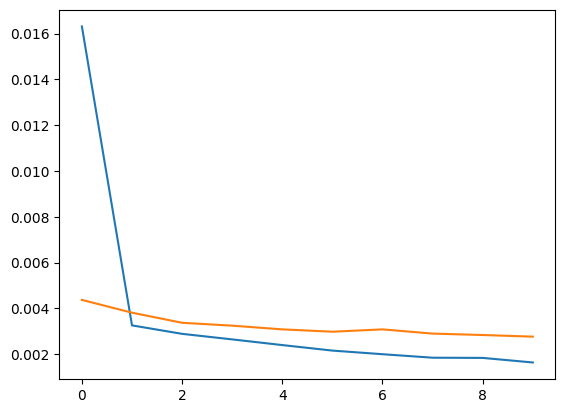

In [10]:
optim = torch.optim.Adam(transformer.parameters(), lr = learning_rate)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for ids_batch, mask_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = transformer.forward(input_ids = ids_batch, attention_mask= mask_batch)
        
        loss = criterion(out.logits, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(transformer, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        transformer.save_pretrained('saved_models/MOVE_AGENT_REQ_' + save_model_name + '_' + SAVE_MODEL_SUFFIX)
        
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [11]:
transformer = AutoModelForSequenceClassification.from_pretrained('saved_models/MOVE_AGENT_REQ_' +  save_model_name + '_' + SAVE_MODEL_SUFFIX, num_labels = len(mlb.classes_)).cuda()

predicted_output = predict(transformer, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                      precision    recall  f1-score   support

   Attraction-Inform      0.545     0.429     0.480        28
  Attraction-NoOffer      0.000     0.000     0.000         1
Attraction-Recommend      0.000     0.000     0.000        10
  Attraction-Request      0.000     0.000     0.000         3
   Attraction-Select      0.000     0.000     0.000         5
        Booking-Book      0.947     0.952     0.949       522
      Booking-Inform      0.000     0.000     0.000       536
      Booking-NoBook      0.707     0.240     0.358       121
     Booking-Request      0.746     0.478     0.583       295
     Hospital-Inform      0.000     0.000     0.000         0
        Hotel-Inform      0.838     0.950     0.890       803
       Hotel-NoOffer      0.000     0.000     0.000        66
     Hotel-Recommend      0.000     0.000     0.000       139
       Hotel-Request      0.575     0.383     0.460       269
        Hotel-Select      0.000     0.000     0.000        78
   Rest

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.